cpu


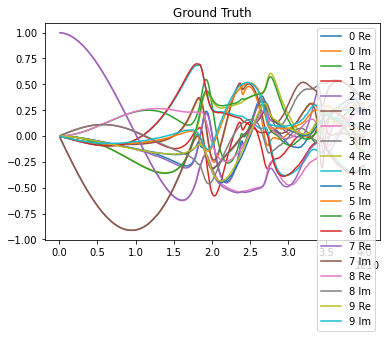

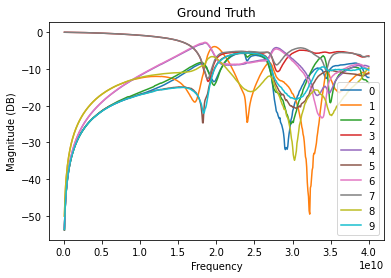

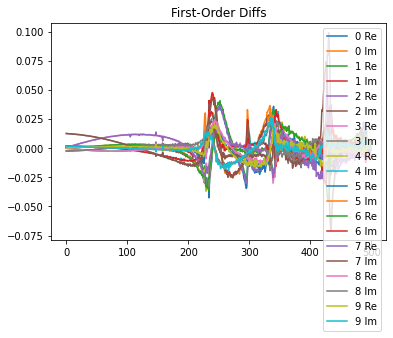

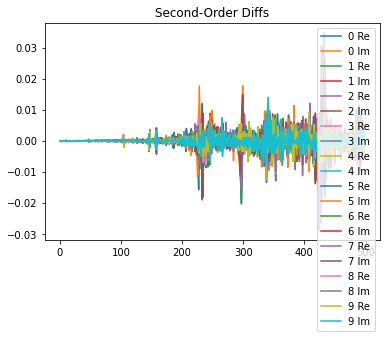

c:\Users\varun\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\Users\varun\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\Users\varun\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


ITER  0
TIME:  0.14500045776367188



In [64]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# Load the data
root_path = "./UTAFSDataNew/new_data"

for chip_num in range(1, 62, 2):
    import utils

    data_dict = utils.grab_chip_data(root_path, chip_num, resample=False)
    data_dict.keys()
    ## Check the data matrices converted from touchstone to np
    # print("GT Data shape: ", data_dict['gt_matrix'].shape)
    # print("VF Data shape: ", data_dict['vf_matrix'].shape)
    # print("Y Data shape: ", data_dict['y_matrix'].shape)
    # print("GT Data type: ", data_dict['gt_matrix'].dtype)
    # print("VF Data type: ", data_dict['vf_matrix'].dtype)
    # print("Y Data type: ", data_dict['y_matrix'].dtype)
    # print("GT frequency shape: ", data_dict['gt_freqs'].shape)
    # print("Y frequency shape: ", data_dict['y_freqs'].shape)
    # print("GT frequency type: ", data_dict['gt_freqs'].dtype)
    # print("Y frequency type: ", data_dict['y_freqs'].dtype)
    ## Calc the Singular values to check the distribution
    temp = np.empty(data_dict['gt_matrix'].shape[:-1], dtype=np.complex64)
    temp.real = data_dict['gt_matrix'][..., 0]
    temp.imag = data_dict['gt_matrix'][..., 1]

    # print("Complex GT data shape: ", temp.shape)
    # print("Complex GT data type: ", temp.dtype)
    vals = np.linalg.svd(temp, compute_uv=False)
    # print("GT data singular values shape: ", vals.shape)
    vals = vals[:,0]
    # print("GT data largest singular values shape: ", vals.shape)
    # print("Max singular value: ", np.amax(vals))
    # print("Min singular value: ", np.amin(vals))
    # plt.figure()
    # plt.hist(vals, density=True, bins=25)
    # plt.show()
    # plt.figure()
    # plt.plot(vals)
    # plt.show()
    ## Convert the raw data matrices to only the unique S-parameters
    vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
    gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
    y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
    # print("VF S-parameters shape: ", vf_data.shape)
    # print("GT S-parameters shape: ", gt_data.shape)
    # print("Y S-parameters shape: ", y_data.shape)
    # print("VF S-parameters type: ", vf_data.dtype)
    # print("GT S-parameters type: ", gt_data.dtype)
    # print("Y S-parameters type: ", y_data.dtype)
    gt_freqs = data_dict['gt_freqs']
    y_freqs = data_dict['y_freqs']
    # print("GT frequencies shape: ", gt_freqs.shape)
    # print("Y frequencies shape: ", y_freqs.shape)
    # print("GT frequencies type: ", gt_freqs.dtype)
    # print("Y frequencies type: ", y_freqs.dtype)
    ## Plot the Ground truth S-parameters 
    n_sparams = gt_data.shape[0]

    plt.figure()
    for i in range(n_sparams):
        plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
        plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
    if n_sparams <= 10:
        plt.legend()
    plt.title("Ground Truth")
    # plt.show()
    gt_mag = utils.to_mag(torch.from_numpy(gt_data))

    # print("GT magniutde shape: ", gt_mag.shape)
    n_sparams = gt_mag.shape[0]

    plt.figure()
    for i in range(n_sparams):
        plt.plot(gt_freqs, gt_mag[i], label=str(i))
    if n_sparams <= 10:
        plt.legend()
    plt.title("Ground Truth")
    plt.ylabel("Magnitude (DB)")
    plt.xlabel("Frequency")
    # plt.show()
    ## Check the data for some smoothness and regularity conditions
    def calc_diffs(x, order=1):
        if order > 1:
            x = calc_diffs(x, order-1)
        
        if isinstance(x, np.ndarray):
            return (x - np.roll(x, -1, 2))[...,:-1] 
        elif torch.is_tensor(x):
            return (x - torch.roll(x, -1, 2))[...,:-1]
    x_diff_1 = calc_diffs(gt_data)

    # print(x_diff_1.shape)

    plt.figure()
    for i in range(n_sparams):
        plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
        plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
    if n_sparams <= 10:
        plt.legend()
    plt.title("First-Order Diffs")
    plt.show()
    x_diff_2 = calc_diffs(gt_data, 2)

    # print(x_diff_2.shape)

    plt.figure()
    for i in range(n_sparams):
        plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
        plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
    if n_sparams <= 10:
        plt.legend()
    plt.title("Second-Order Diffs")
    plt.show()
    ## Grab some measurements
    PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
    LENGTH = len(gt_freqs)
    M = int(y_freqs.shape[0])
    kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)
    # print("LENGTH: ", LENGTH)
    # print("Intended M (num measurements): ", M)
    # print("Actual M (num measurements): ", len(kept_inds))
    # print("(LENGTH - M): ", len(missing_inds))
    ## Make the final data
    x = torch.from_numpy(gt_data)
    x = x.view(-1, LENGTH).unsqueeze(0)
    # print("Final GT data shape: ", x.shape)
    # print("Final GT data type: ", x.dtype)
    y = torch.clone(x)[:, :, kept_inds]
    # print("Final Y data shape: ", y.shape)
    # print("Final Y data type: ", y.dtype)
    y_freqs = gt_freqs[kept_inds] #NOTE - y_freqs was previously the name of the VF used frequencies, changing it here
    # print("Final Y frequencies shape: ", y_freqs.shape)
    # print("Final Y frequencies type: ", y_freqs.dtype)
    ## Check the singular values again with the PyTorch function on the S-parameters
    vals = utils.sparams_to_sing_vals(x)
    vals = vals[:, 0] #grab only the largest singular value
    # print("Largest sing vals shape: ", vals.shape)
    # print("Max singular value: ", torch.max(vals).item())
    # print("Min singular value: ", torch.min(vals).item())
    # plt.figure()
    # plt.hist(vals.numpy(), density=True, bins=25)
    # plt.show()
    # plt.figure()
    # plt.plot(vals.numpy())
    # plt.show()
    ## Check the causaliy of the signal
    evens = [i for i in range(x.shape[1]) if i%2 == 0]
    odds = [i for i in range(x.shape[1]) if i%2 != 0]
    # print("Even indices length: ", len(evens))
    # print("Odd indices length: ", len(odds))
    x_complex = torch.complex(x[:,evens,:], x[:,odds,:])
    # print("Complex x shape: ", x_complex.shape)
    x_time = torch.fft.irfft(x_complex, n=2*x_complex.shape[-1]-1, norm="forward")
    # print("Time-domain x shape: ", x_time.shape)
    # plt.figure()
    # plt.plot(x_time.cpu().numpy()[0,0,:])
    # plt.show()
    ## Try to check the Causality Layer
    from model_parts import CausalityLayer

    Causal_Layer = CausalityLayer(LENGTH, K=1)
    causal_check = Causal_Layer(x[:,evens,:])
    # print("X shape: ", x.shape)
    # print("Causal output shape: ", causal_check.shape)
    # plt.figure()
    for j in range(x.shape[0]):
        for i in range(x.shape[1]):
            label = str(i//2) + (" re" if i % 2 == 0 else " im")
            plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
    plt.title("Ground Truth")
    if n_sparams <= 10:
        plt.legend()
    # plt.show()
    plt.figure()
    for j in range(causal_check.shape[0]):
        for i in range(causal_check.shape[1]):
            label = str(i//2) + (" re" if i % 2 == 0 else " im")
            plt.plot(gt_freqs, causal_check[j,i,:].flatten(), label=label)
    plt.title("Causal Output")
    if n_sparams <= 10:
        plt.legend()
    # plt.show()
    # print("MSE between X and causal recon (should be close to 0): ", torch.mean(torch.square(x - causal_check)).item())
    x_mag = utils.to_mag(x)
    causal_mag = utils.to_mag(causal_check)

    # print("X magnitude shape: ", x_mag.shape)
    # print("Causal recon magnitude shape: ", causal_mag.shape)
    plt.figure()

    for i in range(x_mag.shape[0]):
        plt.plot(gt_freqs, x_mag[i], color="blue")
        plt.plot(gt_freqs, causal_mag[i], color="red")

    plt.title("CAUSAL CHECK and GT Magnitudes Overlaid")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    # plt.show()
    ## Try to check the passivity layer
    ### First make sure it doesnt change OG signals
    from model_parts import PassivityLayer

    Passive_Layer = PassivityLayer()
    passive_check = Passive_Layer(x)
    # print("Passivity recon shape: ", passive_check.shape)
    # print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())
    ### Now scale the OG signal, try to make passive, and compare
    x_scaled = 2. * x
    # print("MSE between X and scaled X: ", torch.mean(torch.square(x - x_scaled)).item())
    scaled_vals = utils.sparams_to_sing_vals(x_scaled)
    scaled_vals = scaled_vals[:, 0] #grab only the largest singular value
    # print("Max singular value of scaled X: ", torch.max(scaled_vals).item())
    # print("Min singular value of scaled X: ", torch.min(scaled_vals).item())
    plt.figure()
    plt.hist(scaled_vals.numpy(), density=True, bins=25)
    # plt.show()
    plt.figure()
    plt.plot(scaled_vals.numpy())
    # plt.show()
    passive_check = Passive_Layer(x_scaled)

    # print("Passive recon shape: ", passive_check.shape)
    # print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())
    passive_vals = utils.sparams_to_sing_vals(passive_check)
    passive_vals = passive_vals[:, 0] #grab only the largest singular value
    # print("Max singular val of passive recon: ", torch.max(passive_vals).item())
    # print("Min singular val of passive recon: ", torch.min(passive_vals).item())
    plt.figure()
    plt.hist(passive_vals.numpy(), density=True, bins=25)
    # plt.show()
    plt.figure()
    plt.plot(passive_vals.numpy())
    # plt.show()
    plt.figure()
    for j in range(x.shape[0]):
        for i in range(x.shape[1]):
            label = str(i//2) + (" re" if i % 2 == 0 else " im")
            plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
    plt.title("Ground Truth")
    if n_sparams <= 10:
        plt.legend()
    # plt.show()
    plt.figure()
    for j in range(passive_check.shape[0]):
        for i in range(passive_check.shape[1]):
            label = str(i//2) + (" re" if i % 2 == 0 else " im")
            plt.plot(gt_freqs, passive_check[j,i,:].flatten(), label=label)
    plt.title("Passive Output")
    if n_sparams <= 10:
        plt.legend()
    # plt.show()
    x_mag = utils.to_mag(x)
    passive_mag = utils.to_mag(passive_check)

    # print("X mag shape", x_mag.shape)
    # print("Passive recon mag shape", passive_mag.shape)
    plt.figure()

    for i in range(x_mag.shape[0]):
        plt.plot(gt_freqs, x_mag[i], color="blue")
        plt.plot(gt_freqs, passive_mag[i], color="red")

    plt.title("PASSIVE CHECK and GT Magnitudes Overlaid")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    # plt.show()
    # Set up the network
    reg_hyperparams = [.1, 1, 10, 100]

    for REG_HYPERPARAM in reg_hyperparams:
        LR = 1e-4 # learning rate
        NUM_ITER = 25000 # number iterations

        NZ = y.shape[1]

        NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 1

        BASE_NGF = 2 ** int(np.ceil(np.log2(NZ)))
        BASE_NGF = max(BASE_NGF, 64)
        BASE_NGF = min(BASE_NGF, 512)

        NGF = [int(BASE_NGF * 2**(i/2)) for i in range(NUM_LAYERS)]

        BS = y.shape[0]
        NC = y.shape[1]
        # print("NZ: ", str(NZ))
        # print("NUM_LAYERS: ", str(NUM_LAYERS))
        # print("BASE NGF: ", str(BASE_NGF))
        # print("NGF: ", str(NGF))
        # print("BS: ", BS)
        # print("NC: ", NC)
        from models import RES_UNET

        KERNEL_SIZE = 1
        USE_SKIP = False
        USE_CAUSAL_PASSIVE = True

        net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, \
                    num_layers=NUM_LAYERS, use_skip=USE_SKIP, causal_passive=USE_CAUSAL_PASSIVE)
        net = net.to(device)
        test_out = net.forward_with_z()
        # print("Net output shape: ", test_out.shape)
        pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

        # print("TOTAL PARAMS: ", pytorch_total_params)
        # for name, param in net.named_parameters():
        #     if param.requires_grad:
        #         print(name + ": ", param.shape)
        # Make the linear interpolation and use it as the input to the network
        import scipy

        y_np = y.cpu().detach().numpy()

        Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')
        y_interp = Interpolate(np.arange(LENGTH))

        # print("Interpolation shape: ", y_interp.shape)
        # fig, axes = plt.subplots(2,1, figsize=(16, 8))
        # axes = axes.flatten()

        # for j in range(x.shape[0]):
        #     for i in range(x.shape[1]):
        #         label = str(i//2) + (" re" if i % 2 == 0 else " im")
        #         axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        #         axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
        # axes[0].set_title("Ground Truth")
        # if n_sparams <= 10:
        #     axes[0].legend()

        # for j in range(x.shape[0]):
        #     for i in range(x.shape[1]):
        #         label = str(i//2) + (" re" if i % 2 == 0 else " im")
        #         axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        #         axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
        # axes[1].set_title("Measurements - Linear interpolation")
        # if n_sparams <= 10:
        #     axes[1].legend()

        # plt.show()
        y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

        # print("Interpolation magnitude shape: ", y_interp_mag.shape)
        x_mag = utils.to_mag(x)
        y_mag = utils.to_mag(y)

        # print("X magnitude shape: ", x_mag.shape)
        # print("Y magnitude shape: ", y_mag.shape)
        # fig, axes = plt.subplots(2,1, figsize=(16, 8))
        # axes = axes.flatten()

        # for j in range(x_mag.shape[0]):
        #     axes[0].plot(gt_freqs, x_mag[j], label=str(j))
        #     axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
        # axes[0].set_title("Ground Truth")
        # axes[0].set_ylabel("Magnitude (DB)")
        # if n_sparams <= 10:
        #     axes[0].legend()

        # for j in range(x_mag.shape[0]):
        #     axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
        #     axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
        # axes[1].set_title("Measurements - Linear interpolation")
        # axes[1].set_ylabel("Magnitude (DB)")
        # axes[1].set_xlabel("Frequency (Hz)")
        # if n_sparams <= 10:
        #     axes[1].legend()

        # plt.show()
        net.set_z(y_interp)

        y_interp = torch.from_numpy(y_interp)
        y_interp = y_interp.to(device)
        # Run
        criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
        criterion = criterion.to(device)

        if REG_HYPERPARAM > 0:
            regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
            regularizer = regularizer.to(device)
        net = net.train()

        optim = torch.optim.Adam(net.parameters(), lr=LR)

        train_losses = []
        train_errors = []
        if REG_HYPERPARAM > 0:
            train_regs = []

        test_mses = []
        test_maes = []

        x = x.to(device)
        y = y.to(device)
        tic = time.time()

        for i in range(NUM_ITER):
            optim.zero_grad()
            
            out = net.forward_with_z()
            
            train_error = criterion(out, y) 
            if REG_HYPERPARAM > 0:
                train_reg = REG_HYPERPARAM * regularizer(out)
                train_loss = train_error + train_reg
            else:
                train_loss = train_error
            
            train_loss.backward()
            optim.step()
            
            with torch.no_grad():
                train_losses.append(train_loss.item())
                train_errors.append(train_error.item())
                if REG_HYPERPARAM > 0:
                    train_regs.append(train_reg.item())
                
                test_mse = nn.MSELoss()(out, x)
                test_mses.append(test_mse.item())
                
                test_mae = nn.L1Loss()(out, x)
                test_maes.append(test_mae.item())

                if (i+1)%1000 == 0 or i == 0:
                    toc = time.time()
                    print("ITER ", str(i))
                    print("TIME: ", str(toc - tic))
                    print()
        # Plot the last output and the metrics
        out = out.detach().clone().cpu()

        # fig, axes = plt.subplots(3,1, figsize=(16, 12))
        # axes = axes.flatten()

        # for j in range(x.shape[0]):
        #     for i in range(x.shape[1]):
        #         label = str(i//2) + (" re" if i % 2 == 0 else " im")
        #         axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        # #         axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
        # axes[0].set_title("Ground Truth")
        # if n_sparams <= 10:
        #     axes[0].legend()

        # for j in range(x.shape[0]):
        #     for i in range(x.shape[1]):
        #         label = str(i//2) + (" re" if i % 2 == 0 else " im")
        #         axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        # #         axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
        # axes[1].set_title("Last Output")
        # if n_sparams <= 10:
        #     axes[1].legend()

        # for j in range(x.shape[0]):
        #     for i in range(x.shape[1]):
        #         label = str(i//2) + (" re" if i % 2 == 0 else " im")
        #         axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
        # #         axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
        # axes[2].set_title("Measurements - Linear interpolation")
        # if n_sparams <= 10:
        #     axes[2].legend()

        # plt.show()
        # out_mag = utils.to_mag(out)

        # print(out_mag.shape)
        # fig, axes = plt.subplots(3,1, figsize=(16, 12))
        # axes = axes.flatten()

        # for j in range(x_mag.shape[0]):
        #     axes[0].plot(gt_freqs, x_mag[j], label=str(j))
        # #     axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
        # axes[0].set_title("Ground Truth")
        # axes[0].set_ylabel("Magnitude (DB)")
        # if n_sparams <= 10:
        #     axes[0].legend()

        # for j in range(x_mag.shape[0]):
        #     axes[1].plot(gt_freqs, out_mag[j], label=str(j))
        # #     axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
        # axes[1].set_title("Last Output")
        # axes[1].set_ylabel("Magnitude (DB)")
        # if n_sparams <= 10:
        #     axes[1].legend()

        # for j in range(x_mag.shape[0]):
        #     axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
        # #     axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
        # axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
        # axes[2].set_ylabel("Magnitude (DB)")
        # axes[2].set_xlabel("Frequency (Hz)")
        # if n_sparams <= 10:
        #     axes[2].legend()

        # plt.show()
        # plt.figure()

        # for i in range(x_mag.shape[0]):
        #     plt.plot(gt_freqs, x_mag[i], color="blue")
        #     plt.plot(gt_freqs, out_mag[i], color="red")

        # plt.title("DIP and GT Magnitudes Overlaid")
        # plt.xlabel("Frequency (Hz)")
        # plt.ylabel("Magnitude (dB)")
        # plt.show()
        # max_idx = 500 #np.argmax(train_losses)

        # plt.figure()
        # plt.plot(train_losses)
        # plt.title("TRAIN LOSS")
        # plt.ylim(0., train_losses[max_idx])
        # plt.show()

        # plt.figure()
        # plt.plot(train_errors)
        # plt.title("TRAIN ERRORS")
        # plt.ylim(0., train_errors[max_idx])
        # plt.show()

        # if REG_HYPERPARAM > 0:
        #     plt.figure()
        #     plt.plot(train_regs)
        #     plt.title("TRAIN REGS")
        #     plt.ylim(0., train_regs[max_idx])
        #     plt.show()

        # plt.figure()
        # plt.plot(test_mses, color='r')
        # plt.title("TEST MSE")
        # plt.ylim(0., test_mses[max_idx])
        # plt.show()

        # plt.figure()
        # plt.plot(test_maes, color='g')
        # plt.title("TEST MAE")
        # plt.ylim(0, test_maes[max_idx])
        # plt.show()
        # Calculate Metrics between DIP, Vector Fit, Linear Interpolation, and the Ground Truth
        # print("\n REGULARIZATION_HYPERPARAM: ", REG_HYPERPARAM)
        # print("FINAL DIP MSE: ", test_mses[-1])
        # print("LINEAR INTERP MSE: ", torch.nn.MSELoss()(x, y_interp).item())

        ## Make neworks from DIP, Interp, and Observations
        DIP_OUT_MATRIX = utils.sparams_to_matrix(out)

        INTERP_MATRIX = utils.sparams_to_matrix(y_interp)

        Y_MATRIX = utils.sparams_to_matrix(y)
        # print(DIP_OUT_MATRIX.shape)
        # print(INTERP_MATRIX.shape)
        # print(Y_MATRIX.shape)
        DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(chip_num))

        INTERP_net = utils.matrix_to_network(INTERP_MATRIX, gt_freqs, "Linear Interpolation With "+str(M)+" Samples for Chip "+str(chip_num))

        Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(chip_num))
        ## Quickly check the singular values of the output
        # temp = DIP_net.s

        # print(temp.shape)
        # print(temp.dtype)
        # vals = np.linalg.svd(temp, compute_uv=False)
        # print(vals.shape)
        # vals = vals[:,0]
        # print(vals.shape)
        # print(np.amax(vals))
        # print(np.amin(vals))
        # plt.figure()
        # plt.hist(vals, density=True, bins=25)
        # plt.show
        # plt.figure()
        # plt.plot(vals)
        # plt.show()
        ## Grab the data back from the networks for DIP and Interp to compare metrics
        DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

        INTERP_FINAL_OUT = np.stack((INTERP_net.s.real, INTERP_net.s.imag), axis=-1)
        # print(DIP_FINAL_OUT.shape)
        # print(INTERP_FINAL_OUT.shape)
        dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
        interp_data = utils.matrix_to_sparams(INTERP_FINAL_OUT)
        # print(dip_data.shape)
        # print(interp_data.shape)
        # print(dip_data.dtype)
        # print(interp_data.dtype)
        ## Compare DIP, VF, and Interp

        data_range = np.amax(gt_data) - np.amin(gt_data)

        psnr_ours = psnr(gt_data, dip_data)#, data_range)
        psnr_interp = psnr(gt_data, interp_data)#, data_range)
        psnr_vf = psnr(gt_data, vf_data)#, data_range)

        print("CHIP NUMBER: ", chip_num)
        print("\n REGULARIZATION_HYPERPARAM: ", REG_HYPERPARAM)
        print("DIP PSNR: ", psnr_ours)
        print("INTERP PSNR: ", psnr_interp)
        print("VF PSNR: ", psnr_vf)
        print("===========================")

## Save the outputs

In [ ]:
# write_path = "/scratch1/04703/sravula"

# DIP_net.write_touchstone(write_path+"/DIP_"+str(chip_num))
# INTERP_net.write_touchstone(write_path+"/INTERP_"+str(chip_num))
# Y_net.write_touchstone(write_path+"/OBSERVATIONS_"+str(chip_num))